**IMPORT USEFUL LIBRARIES**

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime

pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 2

%matplotlib inline

**READ IN DATA**

In [39]:
df = pd.read_csv('/Users/malonzo/Downloads/Take Home Data.csv')
df.head()

,patient_id,acquisition_source,order_id,order_date,delivered_on_time,partnerships_manager,is_patient_recurring,medication_classes
0,37616,Organic,233713,10-10-2018,1,NaN,0,"Electrolyte Balance-Nutritional Products, Geni..."
1,41943,Organic,159926,06-08-2018,1,Jason,0,"Anti-Infective Agents,"
2,41943,Organic,241569,10-20-2018,1,Jason,0,"Anti-Infective Agents,"
3,41943,Organic,249165,10-30-2018,1,Jason,0,"Anti-Infective Agents,"
4,50647,Organic,181908,07-19-2018,1,NaN,0,"Immunosuppressive Agents,"


**ADJUST DATA TYPE OF 'ORDER_DATE' FIELD**

In [40]:
df['order_date'] = pd.to_datetime(df['order_date'])

**CREATE 'OrderPeriod' FIELD BASED ON 'ORDER_DATE' FOR MONTHLY COHORT ANALYSIS**

In [41]:
df['OrderPeriod'] = df.order_date.apply(lambda x: x.strftime('%Y-%m'))
df.head()

,patient_id,acquisition_source,order_id,order_date,delivered_on_time,partnerships_manager,is_patient_recurring,medication_classes,OrderPeriod
0,37616,Organic,233713,2018-10-10,1,NaN,0,"Electrolyte Balance-Nutritional Products, Geni...",2018-10
1,41943,Organic,159926,2018-06-08,1,Jason,0,"Anti-Infective Agents,",2018-06
2,41943,Organic,241569,2018-10-20,1,Jason,0,"Anti-Infective Agents,",2018-10
3,41943,Organic,249165,2018-10-30,1,Jason,0,"Anti-Infective Agents,",2018-10
4,50647,Organic,181908,2018-07-19,1,NaN,0,"Immunosuppressive Agents,",2018-07


**Determine Patient's Cohort Group (based on their first order)**

In [47]:
#df.set_index('patient_id', inplace=True)


df['CohortGroup'] = df.groupby(level=0)['order_date'].min().apply(lambda x: x.strftime('%Y-%m'))
df.reset_index(inplace=True)
df.head()

,patient_id,acquisition_source,order_id,order_date,delivered_on_time,partnerships_manager,is_patient_recurring,medication_classes,OrderPeriod,CohortGroup
0,37616,Organic,233713,2018-10-10,1,NaN,0,"Electrolyte Balance-Nutritional Products, Geni...",2018-10,2018-10
1,41943,Organic,159926,2018-06-08,1,Jason,0,"Anti-Infective Agents,",2018-06,2018-06
2,41943,Organic,241569,2018-10-20,1,Jason,0,"Anti-Infective Agents,",2018-10,2018-06
3,41943,Organic,249165,2018-10-30,1,Jason,0,"Anti-Infective Agents,",2018-10,2018-06
4,50647,Organic,181908,2018-07-19,1,NaN,0,"Immunosuppressive Agents,",2018-07,2018-05


**Rollup data by CohortGroup & OrderPeriod**

In [53]:
grouped = df.groupby(['CohortGroup', 'OrderPeriod'])

# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'patient_id': pd.Series.nunique,
                       'order_id': pd.Series.nunique,
                       'delivered_on_time': np.sum})

# make the column names more meaningful
cohorts.rename(columns={'patient_id': 'TotalPatients',
                        'order_id': 'TotalOrders',
                        'delivered_on_time': 'TotalOrders_DeliveredOnTime'}, inplace=True)
cohorts.head()

TotalPatients  TotalOrders  \
CohortGroup OrderPeriod                               
2018-05     2018-05               1990         2459   
            2018-06                777         1143   
            2018-07                680          988   
            2018-08                647          984   
            2018-09                576          850   

                         TotalOrders_DeliveredOnTime  
CohortGroup OrderPeriod                               
2018-05     2018-05                             2000  
            2018-06                              947  
            2018-07                              867  
            2018-08                              854  
            2018-09                              741

**Label the CohortPeriod for each CohortGroup**

In [74]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()



OrderPeriod  TotalPatients  TotalOrders  \
CohortGroup CohortPeriod                                           
2018-05     1                2018-05           1990         2459   
            2                2018-06            777         1143   
            3                2018-07            680          988   
            4                2018-08            647          984   
            5                2018-09            576          850   

                          TotalOrders_DeliveredOnTime  CohortPeriod  
CohortGroup CohortPeriod                                             
2018-05     1                                    2000             1  
            2                                     947             2  
            3                                     867             3  
            4                                     854             4  
            5                                     741             5

In [76]:
cohorts['%_on_time'] = cohorts['TotalOrders_DeliveredOnTime'] / cohorts['TotalOrders']
cohorts.head()


OrderPeriod  TotalPatients  TotalOrders  \
CohortGroup CohortPeriod                                           
2018-05     1                2018-05           1990         2459   
            2                2018-06            777         1143   
            3                2018-07            680          988   
            4                2018-08            647          984   
            5                2018-09            576          850   

                          TotalOrders_DeliveredOnTime  CohortPeriod  %_on_time  
CohortGroup CohortPeriod                                                        
2018-05     1                                    2000             1   0.813339  
            2                                     947             2   0.828521  
            3                                     867             3   0.877530  
            4                                     854             4   0.867886  
            5                                     741             5   0.871765

**User Retention by Cohort Group**

In [55]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalPatients'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2018-05    1990
2018-06    1948
2018-07    1650
2018-08    2138
2018-09    2058
Name: TotalPatients, dtype: int64

In [56]:
cohorts['TotalPatients'].head()

CohortGroup  CohortPeriod
2018-05      1               1990
             2                777
             3                680
             4                647
             5                576
Name: TotalPatients, dtype: int64

In [58]:
cohorts['TotalPatients'].unstack(0).head()

CohortGroup,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
CohortPeriod,,,,,,,,
1,1990.0,1948.0,1650.0,2138.0,2058.0,2634.0,2445.0,2342.0
2,777.0,768.0,656.0,811.0,864.0,1055.0,889.0,730.0
3,680.0,749.0,604.0,818.0,791.0,945.0,715.0,NaN
4,647.0,686.0,604.0,783.0,748.0,814.0,NaN,NaN
5,576.0,701.0,559.0,729.0,581.0,NaN,NaN,NaN


In [63]:
user_retention = cohorts['TotalPatients'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
CohortPeriod,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.390452,0.394251,0.397576,0.379326,0.419825,0.400532,0.363599,0.311699
3,0.341709,0.384497,0.366061,0.382601,0.384354,0.358770,0.292434,NaN
4,0.325126,0.352156,0.366061,0.366230,0.363460,0.309036,NaN,NaN
5,0.289447,0.359856,0.338788,0.340973,0.282313,NaN,NaN,NaN
6,0.302010,0.327002,0.333333,0.282039,NaN,NaN,NaN,NaN
7,0.286935,0.318275,0.276364,NaN,NaN,NaN,NaN,NaN
8,0.269849,0.261807,NaN,NaN,NaN,NaN,NaN,NaN
9,0.214573,NaN,NaN,NaN,NaN,NaN,NaN,NaN


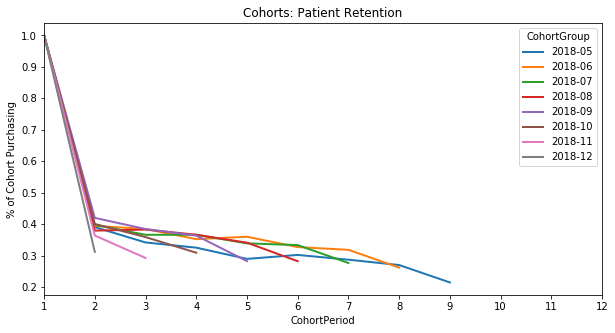

In [64]:
user_retention[['2018-05', '2018-06','2018-07', '2018-08', '2018-09','2018-10', '2018-11', '2018-12']].plot(figsize=(10,5))
plt.title('Cohorts: Patient Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

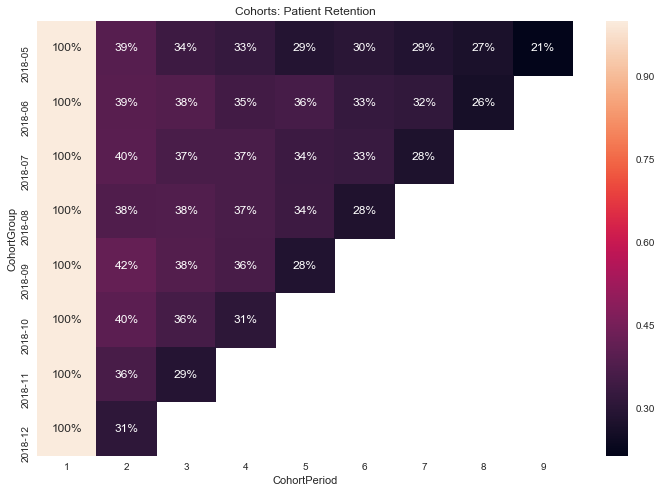

In [70]:
# Creating heatmaps in matplotlib is more difficult than it should be.
# Thankfully, Seaborn makes them easy for us.
# http://stanford.edu/~mwaskom/software/seaborn/

import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: Patient Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

In [ ]:
df.groupby(['acquisition_source']).count()